In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tables
import h5py
from pathlib import Path
from scipy import stats
from pylab import *
import sklearn.metrics
import functools
import warnings
warnings.filterwarnings("ignore")


In [2]:
class Corr:
    # h5文件压缩选项
    h5_common_opts = {"compression": 32001, "compression_opts": (0, 0, 0, 0, 6, 0, 5)}
    # 不同采样频率对应的每日数据点个数 字典
    ntick_per_day={1:241,5:49,30:9}
    # 需要参与分析的数据点个数列表
    data_range=[1, 2, 5, 10, 15, 30, 50,60, 120, 241, 482, 1205]
    # 参与分析的数据点最大值，用于确定参与分析的数据的天数
    max_data_range = np.max(data_range)
    # 交易日期参照表文件
    trade_date_file='D:/data/cache/curated/CN.HSA/dates.csv'
    # 交易日期参照表
    trade_date = pd.to_datetime(
            pd.read_csv(trade_date_file,header=None)[0],format='%Y%m%d')
    # 输入的数据文件路径
    in_data_path = Path('D:/data/cache/curated/CN.HSA/min/basic')
    
    def log(func):
        @functools.wraps(func)
        def wrapper(*args,**kwargs):
            print(f'{pd.Timestamp.now().isoformat()}')
            return func(*args,**kwargs)
        return wrapper
            
    def __init__(self,today,deltatime=1):
        # 相邻数据点的时间间隔 单位为min
        self.deltatime = deltatime
        # 今日的时间戳
        self.today = pd.Timestamp(today)
        # 今日的数据在交易日列表中的序号
        self.todayindex = Corr.trade_date[Corr.trade_date==self.today].index[0]
        # 需要的数据覆盖的天数长度
        self.data_days =  int(np.ceil(Corr.max_data_range / Corr.ntick_per_day[self.deltatime])) 
        # 选取当前日期的数据 security_id 作为其他天的参考索引
        self.ref_index = pd.Index(self.get_fields(Corr.in_data_path/(self.today.strftime('%Y%m%d')+'.h5'),['/security_id'])[0])

    def get_fields(self,filename,fieldlist):
        # 输入的是字段列表，返回的为对应的数据
        ret=[]
        with tables.File(filename,'r') as fh:
            for field in fieldlist:
                data=fh.root[field][()]
                ret.append(data)
        return ret
    
    def reindex_mat(self,index,mat):
        # 输入为原矩阵及其索引，参考索引；输出为重新索引之后的矩阵
        # index为mat的原index
        # mat为输入的矩阵
        ret=np.full((mat.shape[0],len(self.ref_index)),np.nan,dtype=mat.dtype)
        i2o=self.ref_index.get_indexer(index)
        m = i2o>0
        ret[:,i2o[m]]=mat[:,m]
        return ret
    
    def get_forward_return(self):
        """ get forward return from min data.

        :param din: path to input data
        :param today: the date to process
        :param return_spans: spans of the returns to calculate. Strictly increasing.
        :type return_spans: List[int]
        :param days: trading days
        :type days: pandas.DatetimeIndex
        :param deltatime: delta time, minutes 
        """
        
        idate_begin = self.todayindex

        idate_end = idate_begin + self.data_days
        assert len(Corr.trade_date) > idate_end, '超出交易日列表，请补充交易日信息！'
        
        needed_days = [d.strftime('%Y%m%d') for d in Corr.trade_date.iloc[idate_begin:idate_end+1]]

        largemat = []
        for day in needed_days: 
            infile = Corr.in_data_path/(day+'.h5')
            mat = self.get_fields(infile,['/security_id','/1/Return']) # 获得索引、Return
            rmat = self.reindex_mat(mat[0],mat[1]) # 根据sid重新索引
            largemat.append(rmat)
        largemat = np.nan_to_num(np.vstack(largemat))

        n_instrument = largemat.shape[1]
        n_data_range = len(Corr.data_range)
        frets = np.full((n_data_range,Corr.ntick_per_day[self.deltatime], n_instrument),0.0,dtype='f8')
        for i in range(n_data_range):
            for j in range(Corr.ntick_per_day[self.deltatime]):
                frets[i,j,:]=largemat[j+1: j+1+Corr.data_range[i],:].sum(axis=0)
        return frets
    
    def normx(self,mat,method):
        if method == 'same':
            ret = mat
        if method == 'linear':
            ret = (mat-np.mean(mat,axis=0))/(np.max(mat,axis=0)-np.min(mat,axis=0))
        if method == 'gaus':
            ret = (mat-np.mean(mat,axis=0))/(np.std(mat,axis=0))
        if method =='arctan':
            ret = np.arctan(mat)*2/np.pi
        if method == 'arctanh':
            ret = np.arctanh(mat)*2/np.pi
        ret[np.isinf(ret)]=0
        ret[np.isinf(-ret)]=0
        return np.nan_to_num(ret)
    
    def calx(self,xmat,umat,dmat,method):
        if method == 'sum':
            pass
        if method == 'div_sum':
            for i in range(umat.shape[0]):
                for j in range(umat.shape[1]):
                    if(dmat[i,j]<1e-12):
                        xmat[i,j]=0
                    else:
                        xmat[i,j]=umat[i,j]/dmat[i,j]-1
        if method == 'div_sum_reverse':
            for i in range(umat.shape[0]):
                for j in range(umat.shape[1]):
                    if umat[i,j]>dmat[i,j]:
                        if(dmat[i,j]<1e-12):
                            xmat[i,j]=0
                        else:
                            xmat[i,j]=umat[i,j]/dmat[i,j]-1
                    else:
                        if(umat[i,j]<1e-12):
                            xmat[i,j]=0
                        else:
                            xmat[i,j]=-dmat[i,j]/umat[i,j]+1
        if method == 'exp_div_sum':
            xmat = np.exp(umat-dmat)-1
        
        xmat[np.isinf(xmat)]=0
        return np.nan_to_num(xmat)
    
    def get_history_info(self,field,norm_method,cal_method):
        """ get history info from min data.

        :param din: path to input data
        :param today: the date to process
        :param his_spans: history span info to calculate. Strictly increasing.
        :type his_spans: List[int]
        :param days: trading days
        :type days: pandas.DatetimeIndex
        :param deltatime: delta time, minutes
        :param field: get history info of field
        :param operate: default 'sum', simple sum ; 'div sum',  get division with previous one ,then sum.
        """
        
        idate_end= self.todayindex

        if not cal_method == 'sum':
            self.data_days = self.data_days +1 # 额外加1 是由于his的数据做比例求和时，可能会往前移动一个单位。
        
        idate_begin=idate_end-self.data_days
        
        needed_days = [d.strftime('%Y%m%d') for d in Corr.trade_date.iloc[idate_begin:idate_end+1]]

        largemat = []
        for day in needed_days:
            infile = Corr.in_data_path/(day+'.h5')
            mat = self.get_fields(infile,['/security_id','/1/'+field])
            rmat = self.reindex_mat(mat[0],mat[1])
            largemat.append(rmat)
        largemat = np.nan_to_num(np.vstack(largemat))

        if cal_method == 'sum':
            xmat = largemat
        else:
            self.data_days = self.data_days -1 # 将nday调整回去，保证与sum模式的结构一致
            umat  = largemat[Corr.ntick_per_day[self.deltatime]:,:]   #做分子，从日期列表的第二天开始
            dmat = largemat[Corr.ntick_per_day[self.deltatime]-1:-1,:] # 做分母，从日期列表的第一天开始，平移一个单位
            xmat =  np.full_like(umat,0.0,dtype='f8')
            umat = self.normx(umat,norm_method)
            dmat = self.normx(dmat,norm_method)
            xmat = self.calx(xmat,umat,dmat,cal_method)
            xmat = np.nan_to_num(xmat)
            
        n_instrument = xmat.shape[1]
        n_data_range = len(Corr.data_range)
        frets = np.full((n_data_range,Corr.ntick_per_day[self.deltatime], n_instrument),0.0,dtype='f8')
        for i in range(frets.shape[0]):
            for j in range(frets.shape[1]):
                    frets[i,j,:]=xmat[frets.shape[1]*self.data_days+j-Corr.data_range[i]+1: frets.shape[1]*self.data_days+j+1,:].sum(axis=0)             
        return frets
    
    def cut(self,x,y,n=50):
        q = np.linspace(0, 1, n + 1)[1:-1]
        qtl = np.nanquantile([x.min(),x.max()],q)

        ymask = np.isfinite(y)
        res = []
        for i in range(n):
            lb = -np.inf if i==0 else qtl[i-1]
            rb = np.inf if i==n-1 else qtl[i]
            xmask = (lb<= x)&(x<rb) # True or False矩阵
            mask = ymask & xmask

            xm=x[mask]
            ym=y[mask]
            count = np.sum(mask)
            if count < 2:
                continue
            discribe = {
                'count':count,
                'x':{
                    'mean':np.nanmean(xm),
                    'std':np.nanstd(xm),
                    'min':np.nanmin(xm),
                    'max':np.nanmax(xm)
                },
                'y':{
                    'mean':np.nanmean(ym),
                    'std':np.nanstd(ym),
                    'min':np.nanmin(ym),
                    'max':np.nanmax(ym)
                },
                'cross':{
                    'corr':self.get_corr(xm,ym)[0],
                    'r2': self.get_corr(xm,ym)[1]
                }
            }
            res.append(discribe)
        return res
    def get_corr(self,xm,ym):
        try:
            corr = stats.pearsonr(ym,xm)[0]
            r2 = sklearn.metrics.r2_score(ym, xm)
        except Exception as e:
            corr = None
            r2 =None
        finally:
            return corr,r2
    @log
    def draw(self,ax,i_datax_range,i_datay_range,n_xy,field,norm_method,cal_method):
        y = self.get_forward_return()
        x = self.get_history_info(field,norm_method,cal_method)
        res = self.cut(x[i_datax_range].flatten(),y[i_datay_range].flatten(),n_xy)
        xmean =  [v['x']['mean'] for v in res]
        ymean =  [v['y']['mean'] for v in res]
        return ax.plot(xmean,ymean,'.')
    
    @log
    def draw_all(self,i_datax_range,i_datay_range,n_xy):
        field_list = [ 'OpenPrice','ClosePrice', 'HighPrice', 'LowPrice', 'TurnoverDeal', 'TurnoverValue','TurnoverVolume', 'Return','TWAP','VWAP']
        norm_method_list=['same','linear','gaus','arctan','arctanh']
        cal_method_list=['sum','div_sum','div_sum_reverse','exp_div_sum']
        for field in field_list:
            print(f'\033[1;31;42m {field} \033[0m') # 有高亮
            fig,ax=plt.subplots(len(norm_method_list),len(cal_method_list),figsize=(13,12))
            fig.suptitle(field,color='red')
            
            for i,norm_method in enumerate(norm_method_list):
                fig.text(0.05,0.175+(4-i)*0.16,norm_method)
                print(f'\033[1;32;40m {norm_method} \033[0m') # 有高亮
                for j,cal_method in enumerate(cal_method_list):
                    if i == 0:
                        fig.text(0.2*(j+1),0.9,cal_method)
                    print(f'\033[1;35;46m {cal_method} \033[0m') # 有高亮
                    self.draw(ax[i][j],i_datax_range,i_datay_range,n_xy,field,norm_method,cal_method)

In [3]:
a=Corr('2020-06-01')

2020-09-03T11:31:13.164924
 OpenPrice 


<IPython.core.display.Javascript object>


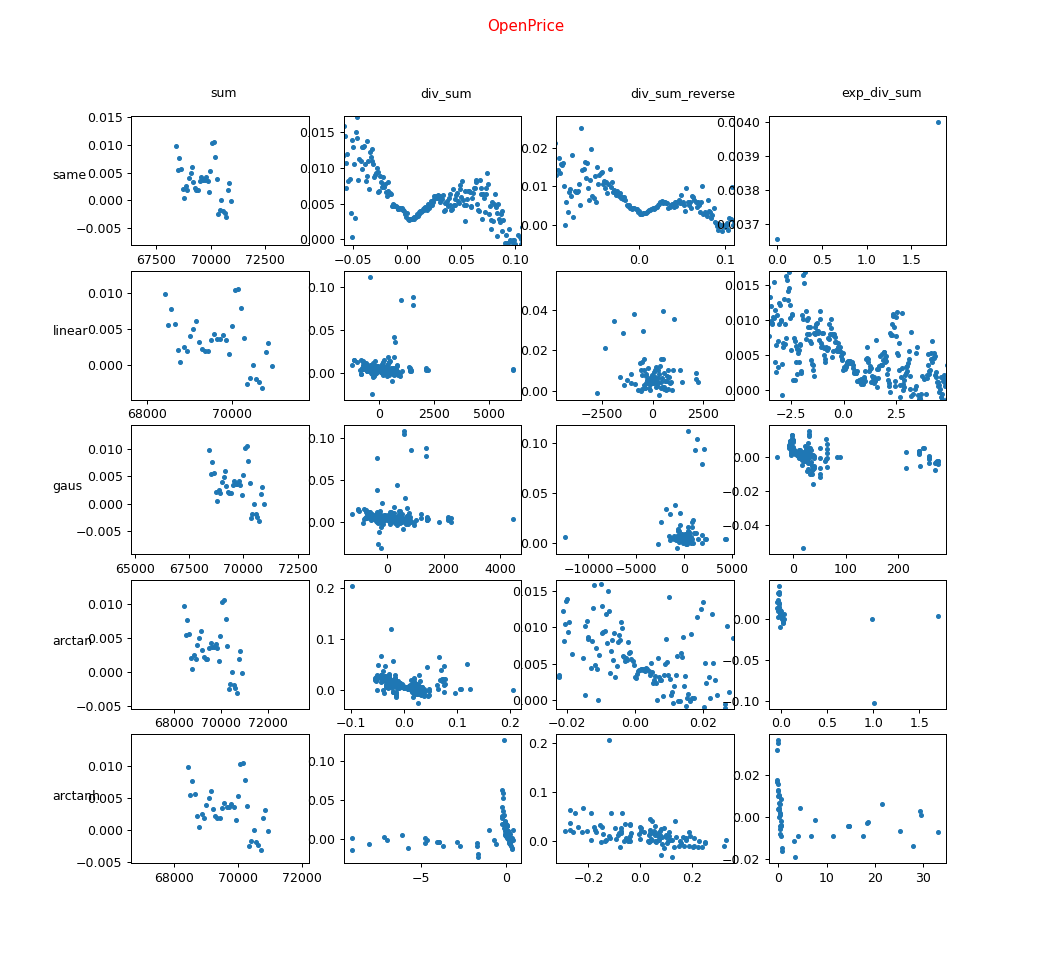

 same 
 sum 
2020-09-03T11:31:13.386330
 div_sum 
2020-09-03T11:31:18.505634
 div_sum_reverse 
2020-09-03T11:31:29.686722
 exp_div_sum 
2020-09-03T11:31:42.837540
 linear 
 sum 
2020-09-03T11:31:48.151354
 div_sum 
2020-09-03T11:31:53.111085
 div_sum_reverse 
2020-09-03T11:32:01.959382
 exp_div_sum 
2020-09-03T11:32:12.675713
 gaus 
 sum 
2020-09-03T11:32:18.584904
 div_sum 
2020-09-03T11:32:23.530673
 div_sum_reverse 
2020-09-03T11:32:32.506659
 exp_div_sum 
2020-09-03T11:32:43.446887
 arctan 
 sum 
2020-09-03T11:32:48.852420
 div_sum 
2020-09-03T11:32:53.975715
 div_sum_reverse 
2020-09-03T11:33:05.090009
 exp_div_sum 
2020-09-03T11:33:18.125137
 arctanh 
 sum 
2020-09-03T11:33:23.461832
 div_sum 
2020-09-03T11:33:28.412617
 div_sum_reverse 
2020-09-03T11:33:35.730010
 exp_div_sum 
2020-09-03T11:33:44.982258
 ClosePrice 


<IPython.core.display.Javascript object>


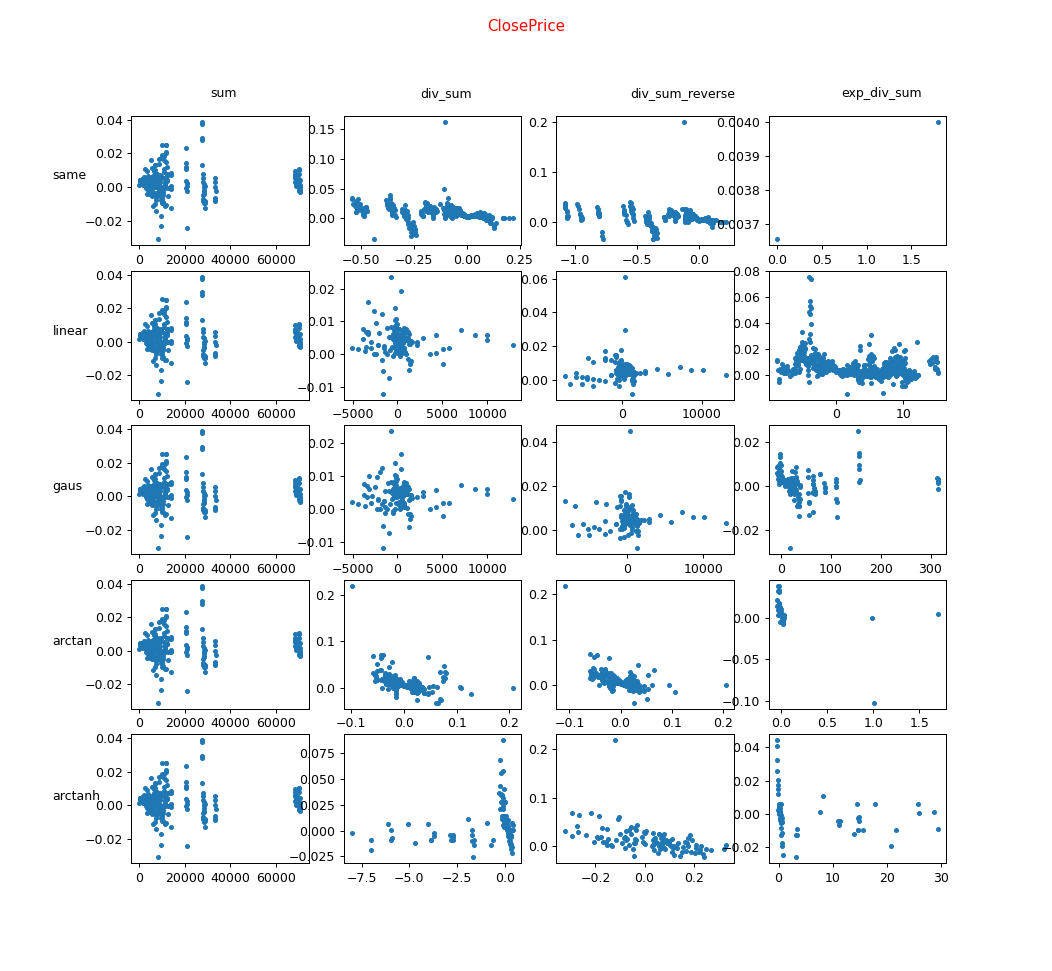

 same 
 sum 
2020-09-03T11:33:50.828616
 div_sum 
2020-09-03T11:33:55.777378
 div_sum_reverse 
2020-09-03T11:34:06.691179
 exp_div_sum 
2020-09-03T11:34:19.558784
 linear 
 sum 
2020-09-03T11:34:24.683045
 div_sum 
2020-09-03T11:34:29.728548
 div_sum_reverse 
2020-09-03T11:34:38.864107
 exp_div_sum 
2020-09-03T11:34:50.013281
 gaus 
 sum 
2020-09-03T11:34:55.804816
 div_sum 
2020-09-03T11:35:00.741579
 div_sum_reverse 
2020-09-03T11:35:09.624813
 exp_div_sum 
2020-09-03T11:35:20.416942
 arctan 
 sum 
2020-09-03T11:35:25.832454
 div_sum 
2020-09-03T11:35:30.764260
 div_sum_reverse 
2020-09-03T11:35:41.685044
 exp_div_sum 
2020-09-03T11:35:54.391080
 arctanh 
 sum 
2020-09-03T11:35:59.606098
 div_sum 
2020-09-03T11:36:04.584779
 div_sum_reverse 
2020-09-03T11:36:11.956060
 exp_div_sum 
2020-09-03T11:36:21.183373
 HighPrice 


<IPython.core.display.Javascript object>


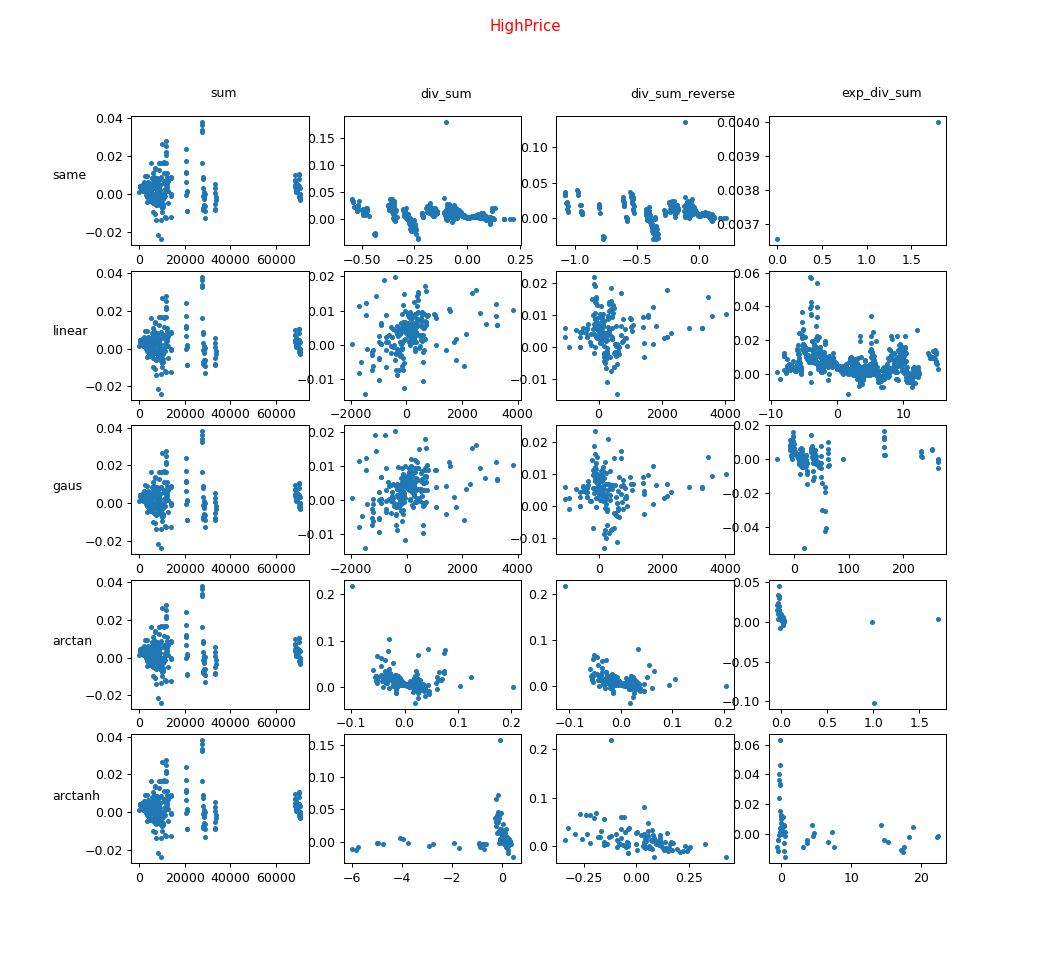

 same 
 sum 
2020-09-03T11:36:27.022752
 div_sum 
2020-09-03T11:36:32.056285
 div_sum_reverse 
2020-09-03T11:36:43.250339
 exp_div_sum 
2020-09-03T11:36:56.470970
 linear 
 sum 
2020-09-03T11:37:01.619197
 div_sum 
2020-09-03T11:37:06.601866
 div_sum_reverse 
2020-09-03T11:37:15.590818
 exp_div_sum 
2020-09-03T11:37:26.471707
 gaus 
 sum 
2020-09-03T11:37:32.430768
 div_sum 
2020-09-03T11:37:37.471282
 div_sum_reverse 
2020-09-03T11:37:46.656174
 exp_div_sum 
2020-09-03T11:37:57.670707
 arctan 
 sum 
2020-09-03T11:38:03.080237
 div_sum 
2020-09-03T11:38:08.022081
 div_sum_reverse 
2020-09-03T11:38:18.725414
 exp_div_sum 
2020-09-03T11:38:31.691726
 arctanh 
 sum 
2020-09-03T11:38:36.965617
 div_sum 
2020-09-03T11:38:41.929337
 div_sum_reverse 
2020-09-03T11:38:49.377412
 exp_div_sum 
2020-09-03T11:38:58.517957
 LowPrice 


<IPython.core.display.Javascript object>


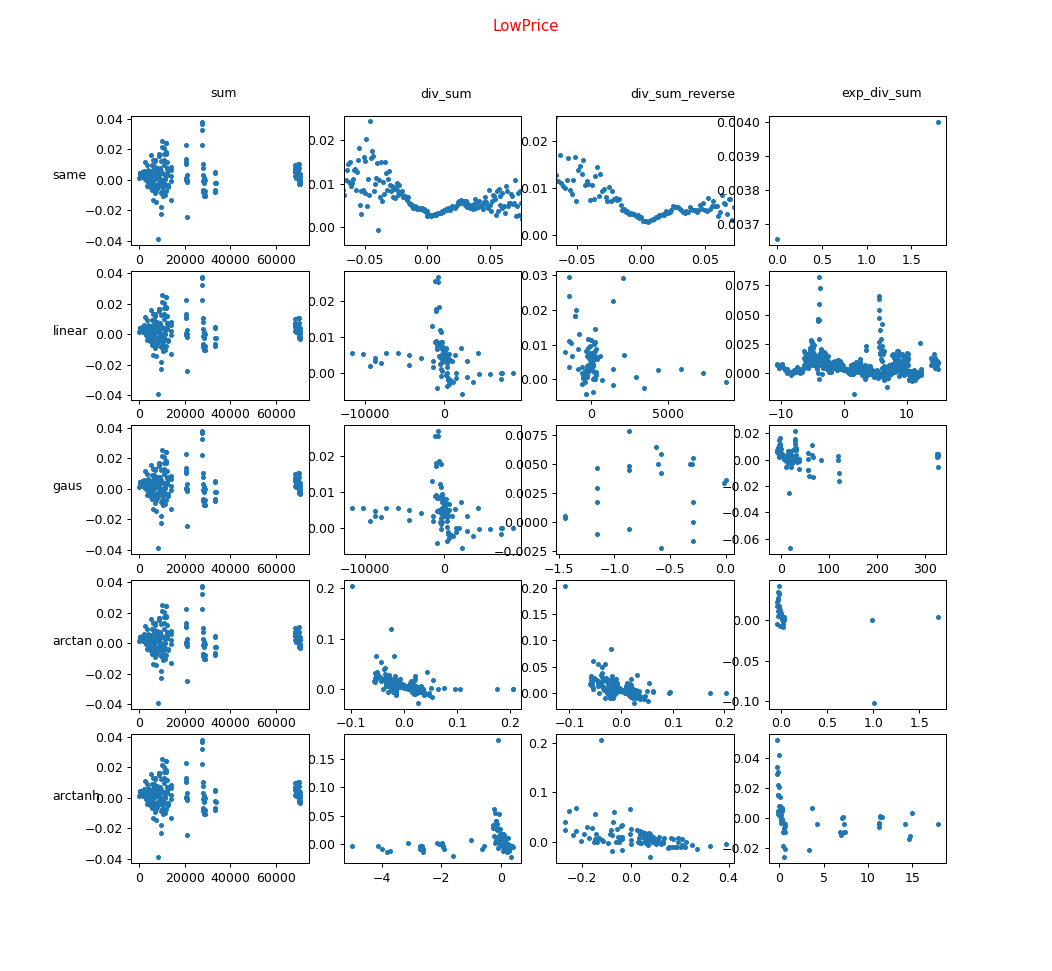

 same 
 sum 
2020-09-03T11:39:04.337388
 div_sum 
2020-09-03T11:39:09.267200
 div_sum_reverse 
2020-09-03T11:39:20.050351
 exp_div_sum 
2020-09-03T11:39:32.812211
 linear 
 sum 
2020-09-03T11:39:37.889627
 div_sum 
2020-09-03T11:39:42.851353
 div_sum_reverse 
2020-09-03T11:39:51.519197
 exp_div_sum 
2020-09-03T11:40:02.238487
 gaus 
 sum 
2020-09-03T11:40:08.058943
 div_sum 
2020-09-03T11:40:13.009669
 div_sum_reverse 
2020-09-03T11:40:21.771852
 exp_div_sum 
2020-09-03T11:40:32.564355
 arctan 
 sum 
2020-09-03T11:40:37.944960
 div_sum 
2020-09-03T11:40:42.925665
 div_sum_reverse 
2020-09-03T11:40:54.177533
 exp_div_sum 
2020-09-03T11:41:07.393177
 arctanh 
 sum 
2020-09-03T11:41:12.730803
 div_sum 
2020-09-03T11:41:17.713507
 div_sum_reverse 
2020-09-03T11:41:25.111714
 exp_div_sum 
2020-09-03T11:41:34.523566
 TurnoverDeal 


<IPython.core.display.Javascript object>


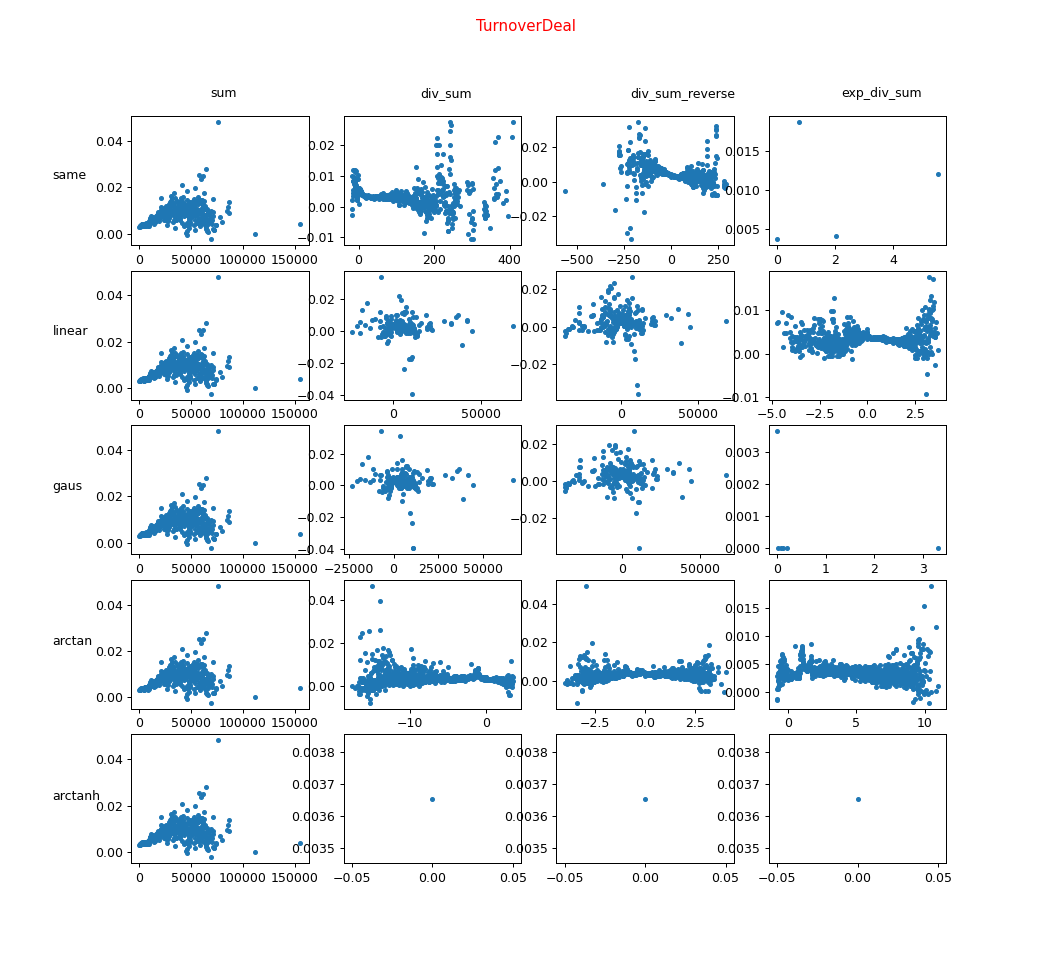

 same 
 sum 
2020-09-03T11:41:40.413777
 div_sum 
2020-09-03T11:41:45.625832
 div_sum_reverse 
2020-09-03T11:41:55.431600
 exp_div_sum 
2020-09-03T11:42:07.272919
 linear 
 sum 
2020-09-03T11:42:12.271576
 div_sum 
2020-09-03T11:42:17.464655
 div_sum_reverse 
2020-09-03T11:42:25.362526
 exp_div_sum 
2020-09-03T11:42:34.916964
 gaus 
 sum 
2020-09-03T11:42:40.804244
 div_sum 
2020-09-03T11:42:45.959451
 div_sum_reverse 
2020-09-03T11:42:54.101640
 exp_div_sum 
2020-09-03T11:43:03.986260
 arctan 
 sum 
2020-09-03T11:43:09.476573
 div_sum 
2020-09-03T11:43:14.639759
 div_sum_reverse 
2020-09-03T11:43:24.744725
 exp_div_sum 
2020-09-03T11:43:36.991962
 arctanh 
 sum 
2020-09-03T11:43:43.185391
 div_sum 
2020-09-03T11:43:48.345587
 div_sum_reverse 
2020-09-03T11:43:55.503467
 exp_div_sum 
2020-09-03T11:44:04.322656
 TurnoverValue 


<IPython.core.display.Javascript object>


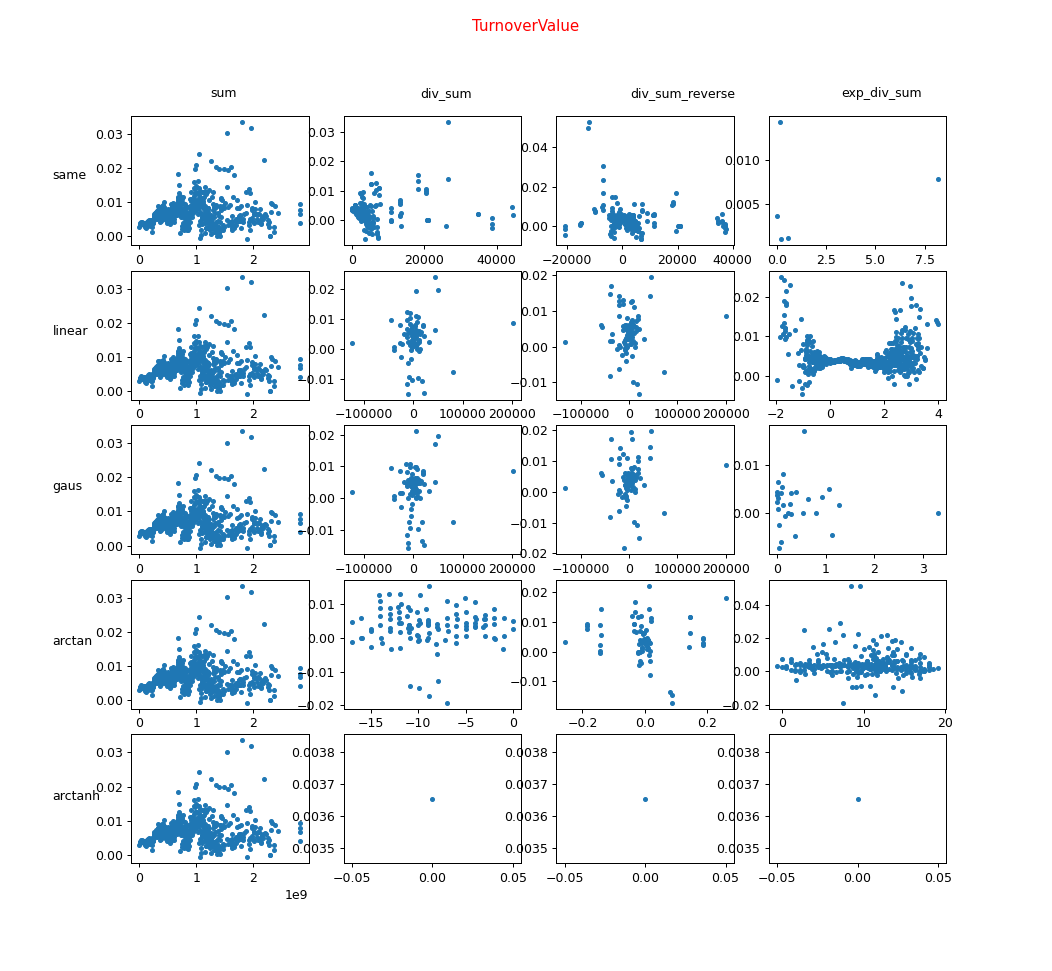

 same 
 sum 
2020-09-03T11:44:09.874801
 div_sum 
2020-09-03T11:44:15.380072
 div_sum_reverse 
2020-09-03T11:44:26.251021
 exp_div_sum 
2020-09-03T11:44:38.986914
 linear 
 sum 
2020-09-03T11:44:44.493182
 div_sum 
2020-09-03T11:44:49.826942
 div_sum_reverse 
2020-09-03T11:44:57.770692
 exp_div_sum 
2020-09-03T11:45:07.552493
 gaus 
 sum 
2020-09-03T11:45:13.576405
 div_sum 
2020-09-03T11:45:19.138497
 div_sum_reverse 
2020-09-03T11:45:27.299662
 exp_div_sum 
2020-09-03T11:45:36.942895
 arctan 
 sum 
2020-09-03T11:45:42.169880
 div_sum 
2020-09-03T11:45:47.522592
 div_sum_reverse 
2020-09-03T11:45:58.468277
 exp_div_sum 
2020-09-03T11:46:10.935595
 arctanh 
 sum 
2020-09-03T11:46:16.446879
 div_sum 
2020-09-03T11:46:21.715784
 div_sum_reverse 
2020-09-03T11:46:29.118949
 exp_div_sum 
2020-09-03T11:46:38.390145
 TurnoverVolume 


<IPython.core.display.Javascript object>


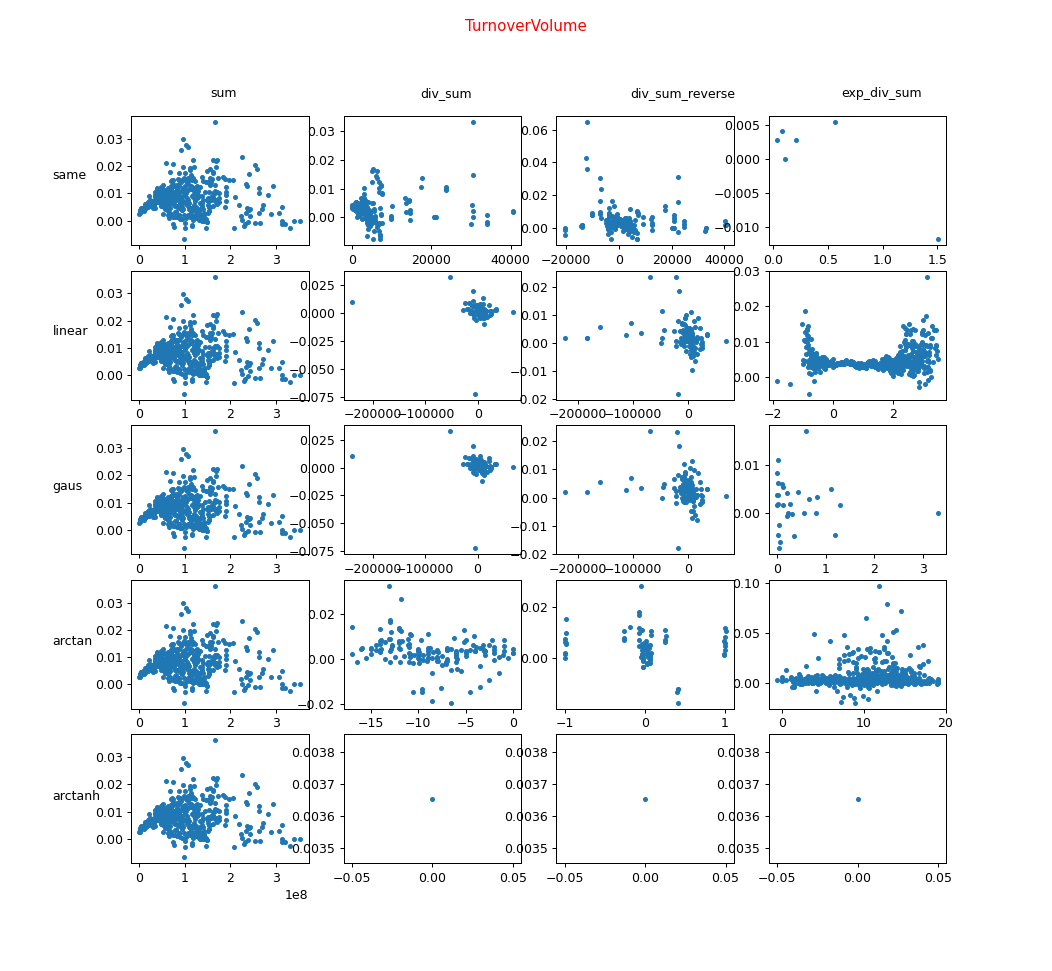

 same 
 sum 
2020-09-03T11:46:44.310342
 div_sum 
2020-09-03T11:46:49.614117
 div_sum_reverse 
2020-09-03T11:46:59.856715
 exp_div_sum 
2020-09-03T11:47:12.283502
 linear 
 sum 
2020-09-03T11:47:17.542401
 div_sum 
2020-09-03T11:47:22.773639
 div_sum_reverse 
2020-09-03T11:47:30.674531
 exp_div_sum 
2020-09-03T11:47:40.274819
 gaus 
 sum 
2020-09-03T11:47:46.181049
 div_sum 
2020-09-03T11:47:51.416011
 div_sum_reverse 
2020-09-03T11:47:59.415325
 exp_div_sum 
2020-09-03T11:48:08.814180
 arctan 
 sum 
2020-09-03T11:48:13.996316
 div_sum 
2020-09-03T11:48:19.192448
 div_sum_reverse 
2020-09-03T11:48:29.803028
 exp_div_sum 
2020-09-03T11:48:42.486128
 arctanh 
 sum 
2020-09-03T11:48:48.175876
 div_sum 
2020-09-03T11:48:53.381948
 div_sum_reverse 
2020-09-03T11:49:00.491926
 exp_div_sum 
2020-09-03T11:49:09.653416
 Return 


<IPython.core.display.Javascript object>


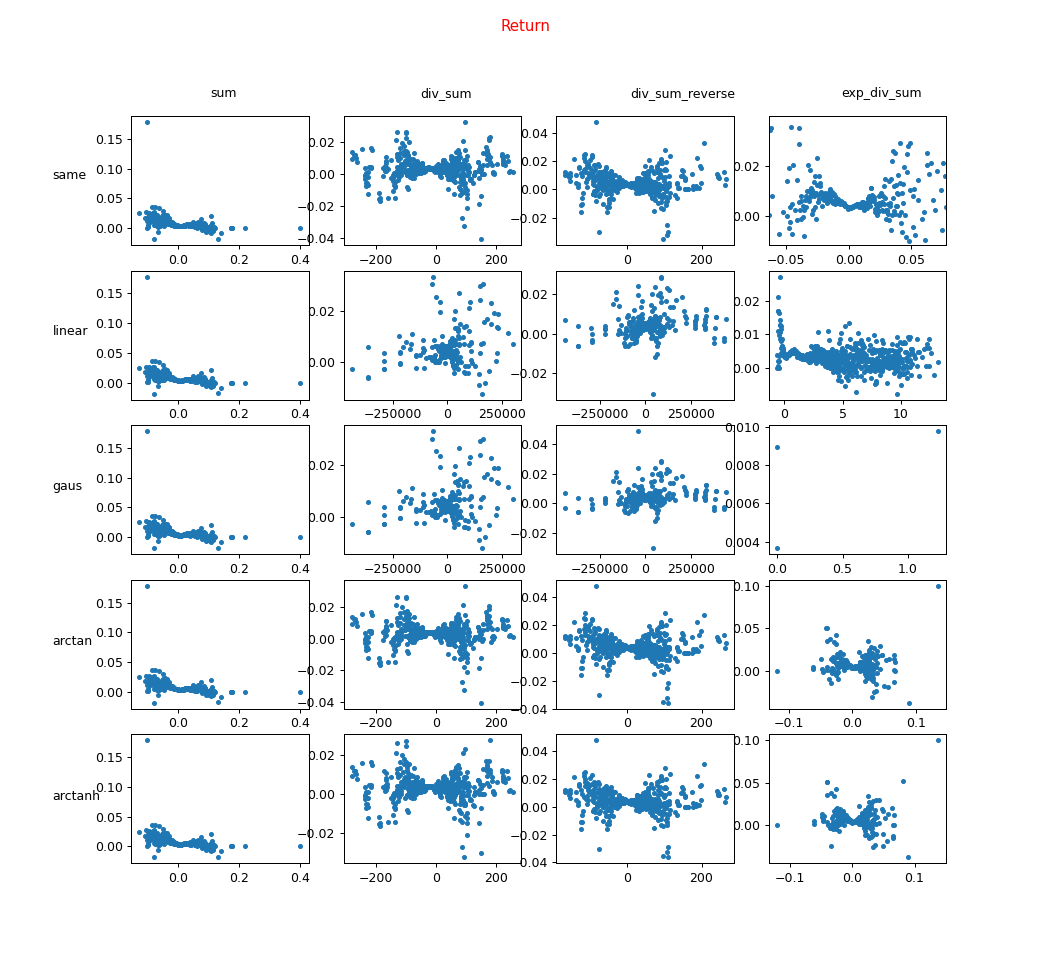

 same 
 sum 
2020-09-03T11:49:15.377105
 div_sum 
2020-09-03T11:49:20.613127
 div_sum_reverse 
2020-09-03T11:49:28.926887
 exp_div_sum 
2020-09-03T11:49:38.368595
 linear 
 sum 
2020-09-03T11:49:43.706315
 div_sum 
2020-09-03T11:49:48.835625
 div_sum_reverse 
2020-09-03T11:49:57.075550
 exp_div_sum 
2020-09-03T11:50:06.706782
 gaus 
 sum 
2020-09-03T11:50:12.488345
 div_sum 
2020-09-03T11:50:17.817059
 div_sum_reverse 
2020-09-03T11:50:26.307345
 exp_div_sum 
2020-09-03T11:50:36.006397
 arctan 
 sum 
2020-09-03T11:50:41.361072
 div_sum 
2020-09-03T11:50:46.550189
 div_sum_reverse 
2020-09-03T11:50:55.009559
 exp_div_sum 
2020-09-03T11:51:04.549068
 arctanh 
 sum 
2020-09-03T11:51:10.042341
 div_sum 
2020-09-03T11:51:15.392029
 div_sum_reverse 
2020-09-03T11:51:24.247340
 exp_div_sum 
2020-09-03T11:51:34.138009
 TWAP 


<IPython.core.display.Javascript object>


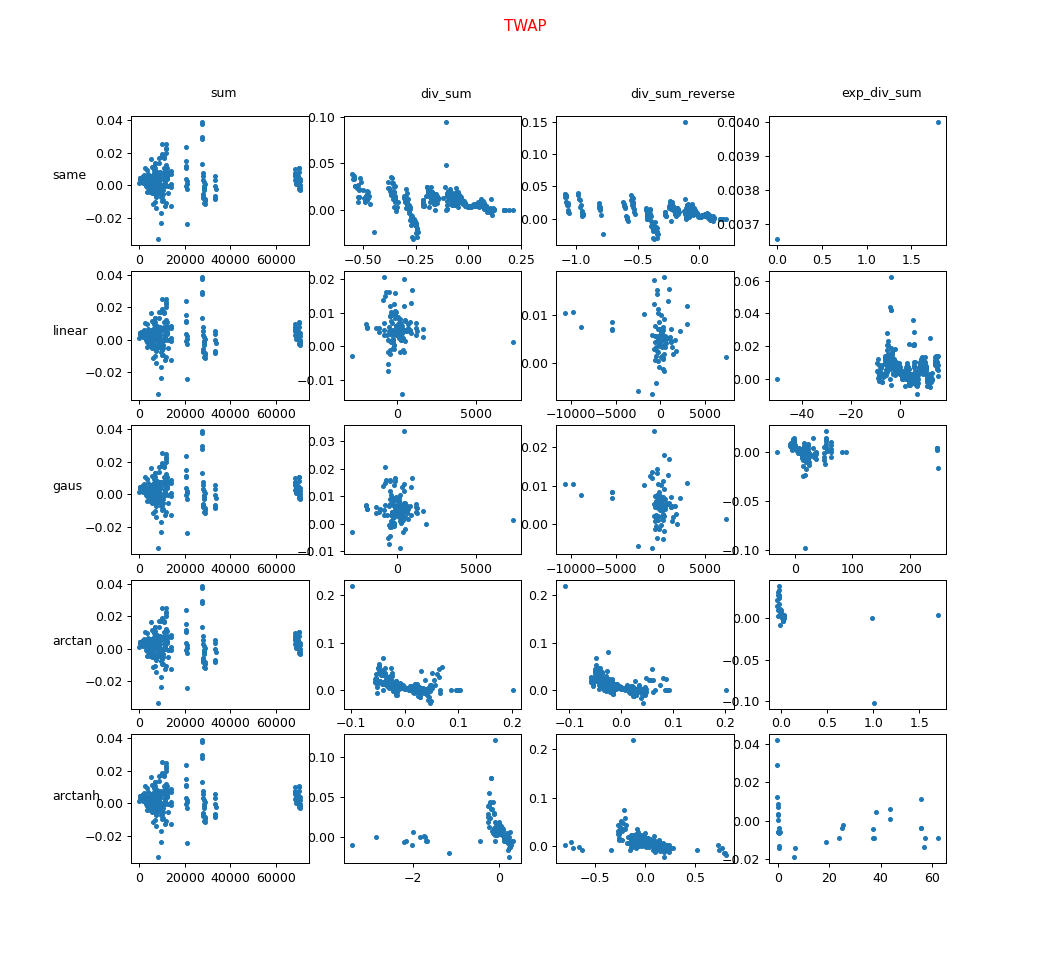

 same 
 sum 
2020-09-03T11:51:39.908542
 div_sum 
2020-09-03T11:51:44.862290
 div_sum_reverse 
2020-09-03T11:51:55.671371
 exp_div_sum 
2020-09-03T11:52:08.601779
 linear 
 sum 
2020-09-03T11:52:13.710114
 div_sum 
2020-09-03T11:52:18.651906
 div_sum_reverse 
2020-09-03T11:52:27.586037
 exp_div_sum 
2020-09-03T11:52:38.449941
 gaus 
 sum 
2020-09-03T11:52:44.082899
 div_sum 
2020-09-03T11:52:49.125409
 div_sum_reverse 
2020-09-03T11:52:58.046514
 exp_div_sum 
2020-09-03T11:53:08.806756
 arctan 
 sum 
2020-09-03T11:53:14.132508
 div_sum 
2020-09-03T11:53:19.036388
 div_sum_reverse 
2020-09-03T11:53:30.307207
 exp_div_sum 
2020-09-03T11:53:43.718328
 arctanh 
 sum 
2020-09-03T11:53:49.075026
 div_sum 
2020-09-03T11:53:54.028776
 div_sum_reverse 
2020-09-03T11:54:01.610490
 exp_div_sum 
2020-09-03T11:54:11.140965
 VWAP 


<IPython.core.display.Javascript object>


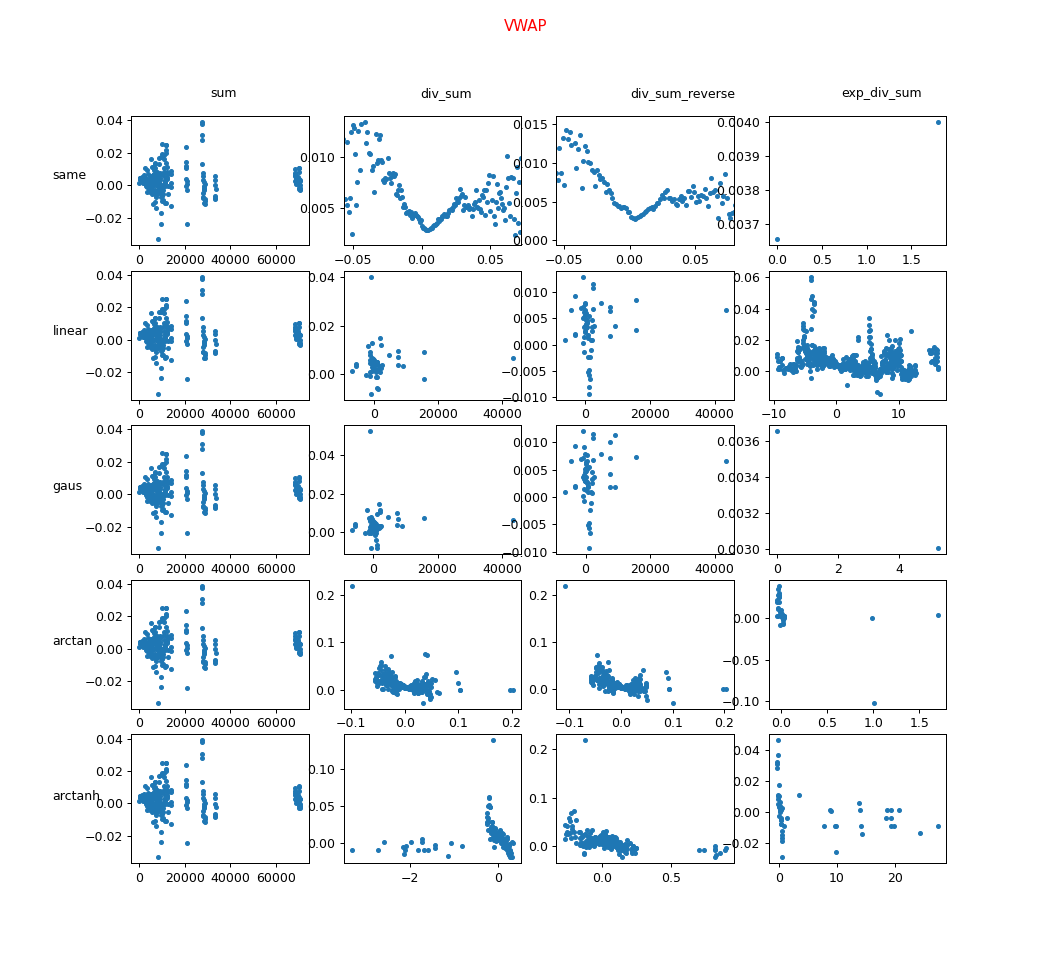

 same 
 sum 
2020-09-03T11:54:16.912556
 div_sum 
2020-09-03T11:54:22.185448
 div_sum_reverse 
2020-09-03T11:54:34.139438
 exp_div_sum 
2020-09-03T11:54:47.701164
 linear 
 sum 
2020-09-03T11:54:52.923213
 div_sum 
2020-09-03T11:54:58.225999
 div_sum_reverse 
2020-09-03T11:55:07.055405
 exp_div_sum 
2020-09-03T11:55:17.792687
 gaus 
 sum 
2020-09-03T11:55:23.755728
 div_sum 
2020-09-03T11:55:28.769285
 div_sum_reverse 
2020-09-03T11:55:37.673494
 exp_div_sum 
2020-09-03T11:55:48.826656
 arctan 
 sum 
2020-09-03T11:55:53.990843
 div_sum 
2020-09-03T11:55:59.054265
 div_sum_reverse 
2020-09-03T11:56:10.348079
 exp_div_sum 
2020-09-03T11:56:24.055379
 arctanh 
 sum 
2020-09-03T11:56:29.323287
 div_sum 
2020-09-03T11:56:34.370812
 div_sum_reverse 
2020-09-03T11:56:41.891662
 exp_div_sum 
2020-09-03T11:56:51.340385


In [4]:
a.draw_all(6,6,1000)